In [20]:
!pip install Pyro-ppl

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
from pyro import distributions as dist
from pyro.contrib import gp

Data generation

In [22]:
def g(x):
  return (-(np.sin(6 * np.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3/2)

In [23]:
def gen_data(l):
  x = np.zeros(l)
  for i in range(l):
    x[i] = i / (l-1)

  epsilon = np.random.normal(0, 0.01, l)
  y = g(x) + epsilon

  return x, y

In [24]:
l = 30
x, y = gen_data(l)
print(x.shape)
print(y.shape)

(30,)
(30,)


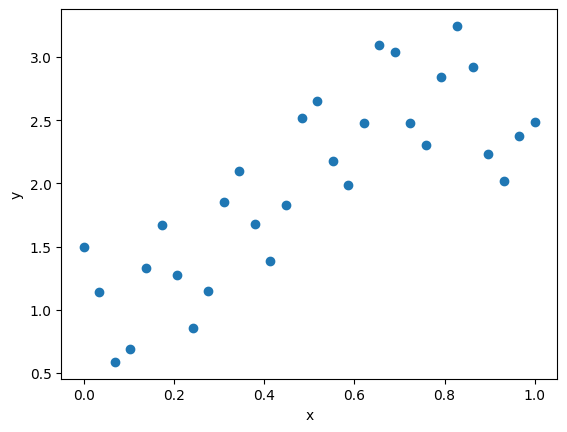

In [25]:
# plot x and y data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [26]:
# partitioning
eval_indx = np.random.choice(l, 10, replace=False)
x_test, y_test = x[eval_indx], y[eval_indx]
x_train, y_train = np.delete(x, eval_indx), np.delete(y, eval_indx)

B.1 Fitting a standard GP

In [80]:
def gpr_model(X, Y):
    input_dim = X.shape[0]

    cos_kernel = gp.kernels.Cosine(input_dim = input_dim)
    prod_kernel = gp.kernels.Product(cos_kernel, cos_kernel)
    poly2_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 2)
    poly4_kernel = gp.kernels.Polynomial(input_dim = input_dim, degree = 4)
    sum_kernel_poly = gp.kernels.Sum(poly2_kernel, poly4_kernel)
    sum_kernel = gp.kernels.Sum(prod_kernel, sum_kernel_poly)
    const_kernel = gp.kernels.Constant(input_dim = input_dim, variance = torch.Tensor([3/2]))

    kernel = gp.kernels.Sum(sum_kernel, const_kernel)

    print(kernel.kern0.kern0.kern0.variance)
    # we pick a "high" variance according to Oswins notes page 16, "Weak priors"
    # further we pick 0 as mean because we have very little data (also page 16, "complexity arguments")
    cos_kernel.variance = pyro.nn.PyroSample(dist.Normal(torch.tensor(0.0), torch.tensor(3.0)))
    print(kernel.kern0.kern0.kern0.variance)
    # lognormal restricting it to positive values
    cos_kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    poly2_kernel.variance = pyro.nn.PyroSample(dist.Normal(torch.tensor(0.0), torch.tensor(3.0)))
    poly4_kernel.variance = pyro.nn.PyroSample(dist.Normal(torch.tensor(0.0), torch.tensor(3.0)))

    gpr = gp.models.GPRegression(
                                  X=torch.tensor(X),
                                  y=torch.tensor(Y),
                                  kernel=kernel,
                                )
    print(gpr.kernel.kern0.kern0.kern1.variance)
    print(gpr.kernel.kern0.kern0.kern1.lengthscale)
    for name, param in gpr.named_parameters():
          print(name, param)
    return gpr

In [41]:
def LogLikelihood(x, y, params, model):
    x = torch.tensor(x)
    y = torch.tensor(y)
    noise_y = params[0]
    eta = params[1:]

    # set kernel parameters
    # cosine kernels
    model.kernel.kern0.kern0.kern0.variance = eta[0]
    model.kernel.kern0.kern0.kern1.variance = eta[0]
    model.kernel.kern0.kern0.kern0.lengthscale = eta[1]
    model.kernel.kern0.kern0.kern1.lengthscale = eta[1]
    # polynomial kernels
    # d=2
    model.kernel.kern0.kern1.kern0.variance = eta[2]
    # d=4
    model.kernel.kern0.kern1.kern1.variance = eta[3]

    # run data trough kernel to compute covariance matrix
    cov_matrix = model.kernel.forward(x)

    # log likelihood
    log_likelihood_first =  1/2 * y.T @ torch.linalg.inv(noise_y * torch.eye(len(x)) + cov_matrix) @ y
    log_likelihood_second =  1/2 * torch.log(torch.linalg.det(noise_y * torch.eye(len(x)) + cov_matrix))
    log_likelihood_third =  len(x)/2 * torch.log(torch.sqrt(2*torch.tensor(np.pi)))
    log_likelihood = - log_likelihood_first - log_likelihood_second - log_likelihood_third
    return log_likelihood

def prior_prob(params):
    eta = params[1:]

    # parameter values
    cos_variance = torch.tensor(eta[0])
    cos_lengthscale = torch.tensor(eta[1])
    poly2_variance = torch.tensor(eta[2])
    poly4_variance = torch.tensor(eta[3])

    # priors
    cos_var_prior = dist.Normal(torch.tensor(0.0), torch.tensor(3.0))
    cos_len_prior = dist.LogNormal(0.0, 1.0)
    poly2_prior = dist.Normal(torch.tensor(0.0), torch.tensor(3.0))
    poly4_prior = dist.Normal(torch.tensor(0.0), torch.tensor(3.0))

    # log P(theta)
    log_prior = cos_var_prior.log_prob(cos_variance) + cos_len_prior.log_prob(cos_lengthscale) + poly2_prior.log_prob(poly2_variance) + poly4_prior.log_prob(poly4_variance)
    return log_prior


def log_likelihood_y_theta(x, y, params):
    # clear parameters to create new model
    pyro.clear_param_store()

    # Define the model
    gpr = gpr_model(x, y)

    # log P(y|X, theta)
    ll = LogLikelihood(x, y, params, gpr)
    # log P(theta)
    prior = prior_prob(params)

    # P(y, theta|x) = P(y|X, theta) * P(theta)
    # log P(y, theta|x) = log P(y|X, theta) + log P(theta)
    return ll + prior

In [81]:
# Test with random parameters
log_likelihood_y_theta(x_train, y_train, [1, 0, 0.2, 0, 0])

tensor(1., grad_fn=<AddBackward0>)
tensor(-4.0243)
-1.4401073455810547
tensor(0.1771)
noise_unconstrained Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True)
kernel.kern0.kern0.kern0.variance_map Parameter containing:
tensor(0.9843, requires_grad=True)
kernel.kern0.kern0.kern0.lengthscale_map_unconstrained Parameter containing:
tensor(-1.7666, requires_grad=True)
kernel.kern0.kern1.kern0.bias_unconstrained Parameter containing:
tensor(0., requires_grad=True)
kernel.kern0.kern1.kern0.variance_map Parameter containing:
tensor(-5.6340, requires_grad=True)
kernel.kern0.kern1.kern1.bias_unconstrained Parameter containing:
tensor(0., requires_grad=True)
kernel.kern0.kern1.kern1.variance_map Parameter containing:
tensor(0.4510, requires_grad=True)
kernel.kern1.variance_unconstrained Parameter containing:
tensor([0.4055], requires_grad=True)


tensor(-22.3461, dtype=torch.float64, grad_fn=<AddBackward0>)

In [31]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

In [48]:
for name, param in gpr.named_parameters():
    print(name, param)

noise_unconstrained Parameter containing:
tensor(0.)
kernel.kern0.kern0.kern0.variance_map Parameter containing:
tensor(-0.7399, requires_grad=True)
kernel.kern0.kern0.kern0.lengthscale_map_unconstrained Parameter containing:
tensor(-0.7465)
kernel.kern0.kern1.kern0.bias_unconstrained Parameter containing:
tensor(0.)
kernel.kern0.kern1.kern0.variance_map Parameter containing:
tensor(1.9852, requires_grad=True)
kernel.kern0.kern1.kern1.bias_unconstrained Parameter containing:
tensor(0.)
kernel.kern0.kern1.kern1.variance_map Parameter containing:
tensor(-0.2334, requires_grad=True)
kernel.kern1.variance_unconstrained Parameter containing:
tensor([0.4055])


In [65]:
# maximum a-posteriori estimate θ∗
pyro.clear_param_store()

# Define the model
gpr = gpr_model(x, y)

# select parameters to optimize
''' params_to_optimize = [
    {'params': [gpr.kernel.kern0.kern0.kern0.variance]},  # cos_kernel variance
    {'params': [gpr.kernel.kern0.kern1.kern0.variance]},  # poly2_kernel variance
    {'params': [gpr.kernel.kern0.kern1.kern1.variance]}  # poly4_kernel variance
] '''
''' params_to_optimize = [
    {'params': [gpr.kernel.kern0.kern0.kern0.variance,      # cos_kernel variance
                gpr.kernel.kern0.kern1.kern0.variance,      # poly2_kernel variance
                gpr.kernel.kern0.kern1.kern1.variance]}     # poly4_kernel variance
] '''

# Disable gradients for fixed parameters
for param in gpr.parameters():
    param.requires_grad = False

# Enable gradient for variable parameters
gpr.kernel.kern0.kern0.kern0.variance.requires_grad = True        # cos_kernel variance
gpr.kernel.kern0.kern0.kern0.lengthscale_map_unconstrained.requires_grad = True     # cos_kernel lengthscale
gpr.kernel.kern0.kern1.kern0.variance.requires_grad = True        # poly2_kernel variance
gpr.kernel.kern0.kern1.kern1.variance.requires_grad = True        # poly4_kernel variance

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    print(i)
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 500 == 0:
      print(gpr.kernel.kern0.kern0.kern1.variance)
      print(gpr.kernel.kern0.kern0.kern1.lengthscale)
      for name, param in gpr.named_parameters():
          print(name, param)

plot_loss(losses)

tensor(-2.2374)
tensor(0.1478)
noise_unconstrained Parameter containing:
tensor(0., requires_grad=True)
kernel.kern0.kern0.kern0.variance_map Parameter containing:
tensor(-3.0253, requires_grad=True)
kernel.kern0.kern0.kern0.lengthscale_map_unconstrained Parameter containing:
tensor(-1.3240, requires_grad=True)
kernel.kern0.kern1.kern0.bias_unconstrained Parameter containing:
tensor(0., requires_grad=True)
kernel.kern0.kern1.kern0.variance_map Parameter containing:
tensor(-3.0472, requires_grad=True)
kernel.kern0.kern1.kern1.bias_unconstrained Parameter containing:
tensor(0., requires_grad=True)
kernel.kern0.kern1.kern1.variance_map Parameter containing:
tensor(0.9791, requires_grad=True)
kernel.kern1.variance_unconstrained Parameter containing:
tensor([0.4055], requires_grad=True)
0
tensor(-1.4635)
tensor(1.6857)
noise_unconstrained Parameter containing:
tensor(0.)
kernel.kern0.kern0.kern0.variance_map Parameter containing:
tensor(-3.0253)
kernel.kern0.kern0.kern0.lengthscale_map_unco

KeyboardInterrupt: 